# Prediction

## Load preprocessed dataframes

In [12]:
from utils import *

train_df = pd.read_pickle("../out/train.pkl")
test_df = pd.read_pickle("../out/test.pkl")

## Columns to drop and feature target

In [13]:
columns_to_drop = ["loan_id", "status"]
target_column = "status"

train_df.drop(columns_to_drop, axis=1).head()

,loan_amount,payments,issuance_frequency_per_month,no. of municipalities with inhabitants < 499,no. of cities,balance_mean,balance_min,client_count_mean,operation_count,type_transaction_count_withdrawal,num_times_under_zero,account_age,days_since_last_transaction
0,80952,3373,1.000000,0,1,32590.624074,1100.0,2.0,44,32,False,313,5
1,30276,2523,1.000000,87,7,25197.092500,715.0,1.0,56,34,False,388,19
2,165960,6915,1.000000,74,8,52523.244800,700.0,1.0,107,88,False,561,2
3,88440,7370,13.044643,9,8,62778.090323,200.0,2.0,25,15,False,179,6
4,104808,8734,1.000000,151,5,38709.830000,500.0,2.0,25,18,False,186,6


## Tune Models

### Decision Tree

In [14]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

parameter_grid = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': range(1, 7)
}

dt, dt_fs, dt_os, dt_fs_os = (tune_model(
    train_df, 
    DecisionTreeClassifier(),
    parameter_grid, 
    columns_to_drop, 
    target_column,
    oversample=oversample,
    feature_selection=feature_selection
) for oversample, feature_selection in ((False, False), (False, True), (True, False), (True,True)))

Best score: 0.8490394088669951
Best parameters: {'model__criterion': 'entropy', 'model__max_depth': 3, 'model__splitter': 'random'}
Best score: 0.8708559113300491
Best parameters: {'model__criterion': 'entropy', 'model__max_depth': 5, 'model__splitter': 'random'}
Best score: 0.8335652709359607
Best parameters: {'model__criterion': 'entropy', 'model__max_depth': 3, 'model__splitter': 'random'}
Best score: 0.8182881773399014
Best parameters: {'model__criterion': 'gini', 'model__max_depth': 4, 'model__splitter': 'random'}


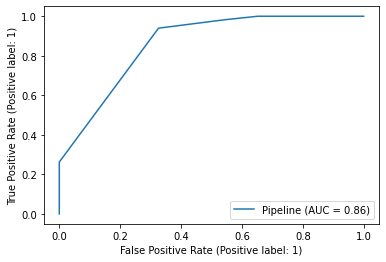

In [15]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_estimator(dt.best_estimator_, train_df.drop(columns_to_drop, axis=1), train_df[target_column])

### SVM
Needs to be scaled (StandardScaler)

In [16]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

parameter_grid = {
    'C': [1, 10, 50],
    'gamma': [0.001, 0.0001],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
}

svc, svc_fs, svc_os, svc_fs_os = (tune_model(
    train_df, 
    SVC(probability=True), 
    parameter_grid,
    columns_to_drop, 
    target_column, 
    scaler=StandardScaler(),
    oversample=oversample,
    feature_selection=feature_selection
) for oversample, feature_selection in ((False, False), (False, True), (True, False), (True,True)))

Best score: 0.8944088669950739
Best parameters: {'model__C': 1, 'model__gamma': 0.001, 'model__kernel': 'linear'}
Best score: 0.8770320197044335
Best parameters: {'model__C': 10, 'model__gamma': 0.001, 'model__kernel': 'linear'}
Best score: 0.8756465517241381
Best parameters: {'model__C': 50, 'model__gamma': 0.0001, 'model__kernel': 'sigmoid'}
Best score: 0.8777894088669951
Best parameters: {'model__C': 1, 'model__gamma': 0.001, 'model__kernel': 'rbf'}


In [ ]:
RocCurveDisplay.from_estimator(svc.best_estimator_, train_df.drop(columns_to_drop, axis=1), train_df[target_column])

###  K-nearest neighbours (KNN)
Just like the SVM model, the KNN model also requires the data to be scaled.

In [17]:
from sklearn import neighbors

parameter_grid = {
    'n_neighbors': [4, 5, 6, 7, 10, 15],
    'leaf_size': [5, 10, 15, 20, 50, 100],
    'n_jobs': [-1],
    'algorithm': ['auto']
}

knn, knn_fs, knn_os, knn_fs_os = (tune_model(
    train_df, 
    neighbors.KNeighborsClassifier(), 
    parameter_grid, 
    columns_to_drop, 
    target_column, 
    scaler=StandardScaler(),
    oversample=oversample,
    feature_selection=feature_selection
) for oversample, feature_selection in ((False, False), (False, True), (True, False), (True,True)))

Best score: 0.8465363300492612
Best parameters: {'model__algorithm': 'auto', 'model__leaf_size': 5, 'model__n_jobs': -1, 'model__n_neighbors': 7}
Best score: 0.838445197044335
Best parameters: {'model__algorithm': 'auto', 'model__leaf_size': 5, 'model__n_jobs': -1, 'model__n_neighbors': 4}
Best score: 0.8663023399014778
Best parameters: {'model__algorithm': 'auto', 'model__leaf_size': 5, 'model__n_jobs': -1, 'model__n_neighbors': 15}
Best score: 0.8631188423645322
Best parameters: {'model__algorithm': 'auto', 'model__leaf_size': 15, 'model__n_jobs': -1, 'model__n_neighbors': 15}


In [ ]:
RocCurveDisplay.from_estimator(knn.best_estimator_, train_df.drop(columns_to_drop, axis=1), train_df[target_column])

### Naïve Bayes

In [18]:
from sklearn.naive_bayes import GaussianNB

parameter_grid = {}

nb, nb_fs, nb_os, nb_fs_os = (tune_model(
    train_df, 
    GaussianNB(),
    parameter_grid, 
    columns_to_drop, 
    target_column, 
    scaler=StandardScaler(),
    oversample=oversample,
    feature_selection=feature_selection
) for oversample, feature_selection in ((False, False), (False, True), (True, False), (True,True)))

Best score: 0.8785591133004926
Best parameters: {}
Best score: 0.8607019704433497
Best parameters: {}
Best score: 0.8699876847290641
Best parameters: {}
Best score: 0.8368903940886699
Best parameters: {}


C:\Python39\lib\site-packages\sklearn\base.py:434: UserWarning: X has feature names, but GaussianNB was fitted without feature names
  warnings.warn(


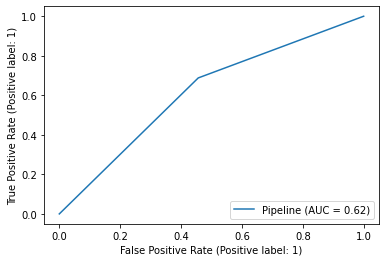

In [23]:
RocCurveDisplay.from_estimator(nb.best_estimator_, train_df.drop(columns_to_drop, axis=1), train_df[target_column])

### Random Forest Classifier

In [19]:
from sklearn.ensemble import RandomForestClassifier

parameter_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [5, 10, 15],
    'n_jobs': [-1],  # Use all cores
    'criterion': ['gini', 'entropy']
}

rfc, rfc_fs, rfc_os, rfc_fs_os = (tune_model(
    train_df, 
    RandomForestClassifier(), 
    parameter_grid, 
    columns_to_drop, 
    target_column,
    oversample=oversample,
    feature_selection=feature_selection
) for oversample, feature_selection in ((False, False), (False, True), (True, False), (True,True)))

Best score: 0.876884236453202
Best parameters: {'model__criterion': 'entropy', 'model__max_depth': 5, 'model__n_estimators': 200, 'model__n_jobs': -1}
Best score: 0.8751631773399016
Best parameters: {'model__criterion': 'entropy', 'model__max_depth': 5, 'model__n_estimators': 10, 'model__n_jobs': -1}
Best score: 0.8740517241379312
Best parameters: {'model__criterion': 'entropy', 'model__max_depth': 10, 'model__n_estimators': 200, 'model__n_jobs': -1}
Best score: 0.878756157635468
Best parameters: {'model__criterion': 'entropy', 'model__max_depth': 10, 'model__n_estimators': 10, 'model__n_jobs': -1}


In [ ]:
RocCurveDisplay.from_estimator(rfc.best_estimator_, train_df.drop(columns_to_drop, axis=1), train_df[target_column])

## Logistic Regression

In [20]:
from sklearn.linear_model import LogisticRegression

parameter_grid = {
    "max_iter": [1000, 5000, 10000],
    "solver": ["lbfgs"]
}

lr, lr_fs, lr_os, lr_fs_os = (tune_model(
    train_df,
    LogisticRegression(),
    parameter_grid,
    columns_to_drop,
    target_column,
    scaler=StandardScaler(),
    oversample=oversample,
    feature_selection=feature_selection
) for oversample, feature_selection in ((False, False), (False, True), (True, False), (True,True)))

Best score: 0.8812684729064039
Best parameters: {'model__max_iter': 1000, 'model__solver': 'lbfgs'}
Best score: 0.887487684729064
Best parameters: {'model__max_iter': 1000, 'model__solver': 'lbfgs'}
Best score: 0.8842426108374383
Best parameters: {'model__max_iter': 1000, 'model__solver': 'lbfgs'}
Best score: 0.8845689655172413
Best parameters: {'model__max_iter': 5000, 'model__solver': 'lbfgs'}


In [ ]:
RocCurveDisplay.from_estimator(lr.best_estimator_, train_df.drop(columns_to_drop, axis=1), train_df[target_column])

## Comparing Models

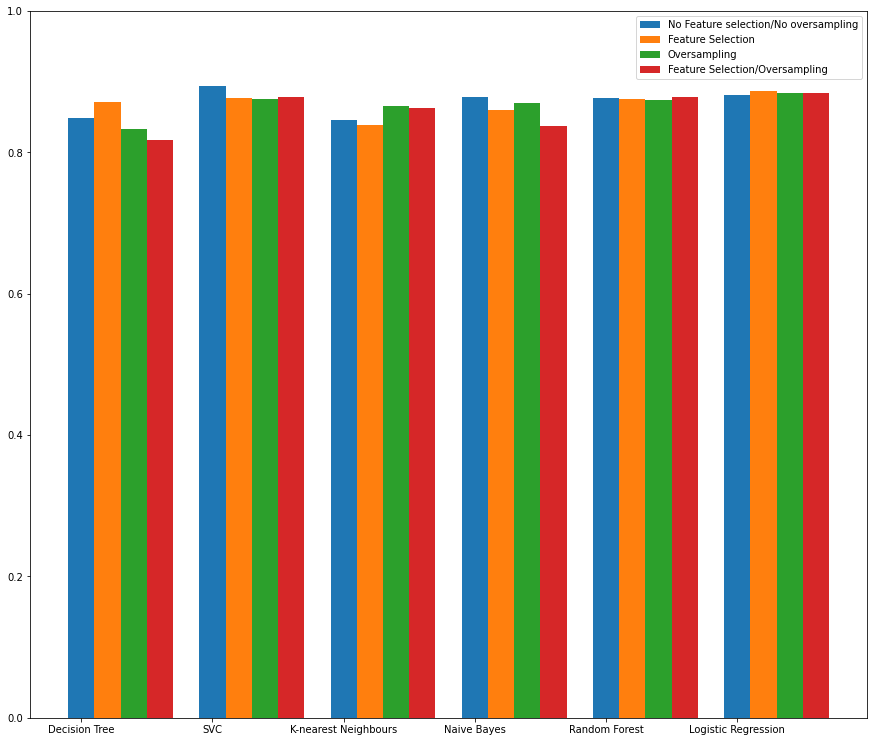

In [21]:
scores = {
    "Decision Tree": [dt, dt_fs, dt_os, dt_fs_os],
    "SVC": [svc, svc_fs, svc_os, svc_fs_os],
    "K-nearest Neighbours": [knn, knn_fs, knn_os, knn_fs_os],
    "Naive Bayes": [nb, nb_fs, nb_os, nb_fs_os],
    "Random Forest": [rfc, rfc_fs, rfc_os, rfc_fs_os],
    "Logistic Regression": [lr, lr_fs, lr_os, lr_fs_os]
}

labels = ["No Feature selection/No oversampling", "Feature Selection", "Oversampling", "Feature Selection/Oversampling"]

ind = np.arange(6)

plt.figure(figsize=(15, 13))
plt.bar(ind, [i[0].best_score_ for i in scores.values()], 0.2)

ax = plt.bar(ind + 0.2, [i[1].best_score_ for i in scores.values()], 0.2)
ax = plt.bar(ind + 0.4, [i[2].best_score_ for i in scores.values()], 0.2)
ax = plt.bar(ind + 0.6, [i[3].best_score_ for i in scores.values()], 0.2)

plt.xticks(ind, scores.keys())
plt.legend(labels, loc=1)
plt.ylim(0, 1)
plt.show()

## Save results

In [22]:
X_result = test_df.drop(columns_to_drop, axis=1)

y_result = svc.predict_proba(X_result)[:, 1]

result = pd.DataFrame({"Id": test_df["loan_id"], "Predicted": y_result})
result.drop_duplicates(inplace=True)
result.to_csv("../out/result.csv", index=False)